# Training the model and evaluation

In this notebook we will explain how the model was trained and how its evaluation could be performed. The code contained here is essentially the same that can be found in train_model.py

In [1]:
import pickle
import os
import re
import numpy as np
import pandas as pd
from random import shuffle
#utils module can be found in src folder
from utils import Config, strip_extension, read_clean, get_y

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score 

import matplotlib.pyplot as plt
import multiprocessing

n_jobs=multiprocessing.cpu_count()

Before training the model let's see what an article looks like

In [3]:
txts = os.listdir(Config.txt_db)
idxs=[strip_extension(txt) for txt in txts]

with open(os.path.join(Config.txt_db,txts[0]),'r') as file:
    article=file.read()
print(article[:1000])

EUROPEAN ORGANISATION FOR NUCLEAR RESEARCH (CERN)

arXiv:1402.7029v3 [hep-ex] 6 May 2014

CERN-PH-EP-2014-019
Submitted to: JHEP

Search for direct production of charginos and neutralinos in
events with three leptons and missing transverse momentum in
√
s = 8 TeV pp collisions with the ATLAS detector

The ATLAS Collaboration

Abstract
A search for the direct production of charginos and neutralinos in final states with three leptons
√
and missing transverse momentum is presented. The analysis is based on 20.3 fb−1 of s = 8 TeV
proton–proton collision data delivered by the Large Hadron Collider and recorded with the ATLAS
detector. Observations are consistent with the Standard Model expectations and limits are set in Rparity-conserving phenomenological Minimal Supersymmetric Standard Models and in simplified supersymmetric models, significantly extending previous results. For simplified supersymmetric models
±
0
of direct chargino (χ̃1 ) and next-to-lightest neutralino (χ̃2 ) production 

As can be seen at the beginning of each article, arXiv.org places the title, the id and the class of the paper. Since we are trying to write an application that determines the class of an input article, it is reasonable to remove these information from the articles.  It is clear that we should remove the class as it might be possible that the model would pick up the classes and therefore classify the papers based on it. We remove the article name because there might be other articles referencing the paper, which might help classifying it, while the model is intended to be used for papers that would be completely new. 

This justifies the definition of function utils.read_clean(), that cleans the articles in the database before feeding them to the model

In [5]:
txts = os.listdir(Config.txt_db)
idxs=[strip_extension(txt) for txt in txts]

max_features=60000

tfidf = TfidfVectorizer(input='content',encoding='utf-8', decode_error='replace', 
             strip_accents='unicode',lowercase=True, analyzer='word', stop_words='english', 
             token_pattern=r'(?u)\b[a-zA-Z_][a-zA-Z0-9_]+\b', ngram_range=(1, 2),
             max_features = max_features, norm='l2', use_idf=True, smooth_idf=True, 
             sublinear_tf=True, max_df=1.0, min_df=2)

#hard copy of the list of papers
train_txt_paths = list(idxs) 
#shuffle the list of articles and crop it
shuffle(train_txt_paths) 
max_train=70000
train_txt_paths = train_txt_paths[:min(len(train_txt_paths), max_train)]
#prepare the corpus
train_corpus = read_clean(train_txt_paths)
#fit the model
print('Training the TFIDF vectorizer.')
tfidf.fit(train_corpus)


Training the TFIDF vectorizer.


TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=60000,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True,
                token_pattern='(?u)\\b[a-zA-Z_][a-zA-Z0-9_]+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

We can have a look at the features learned by the model look like and save the model

In [6]:
items=tfidf.vocabulary_.items()
print( [v for v in list(tfidf.vocabulary_.keys())[0:200]])

['slow', 'quantum', 'thermalization', 'body', 'revivals', 'mixed', 'phase', 'space', 'jan', 'ist', 'austria', 'campus', 'school', 'physics', 'astronomy', 'university', 'leeds', 'ls2', 'united', 'kingdom', 'department', 'theoretical', 'geneva', 'switzerland', 'dated', 'january', 'relaxation', 'systems', 'strongly', 'depend', 'initial', 'state', 'semiclassical', 'regions', 'chaotic', 'motion', 'coexist', 'regular', 'islands', 'recent', 'years', 'effort', 'understand', 'process', 'interacting', 'lack', 'obvious', 'limit', 'time', 'dependent', 'variational', 'principle', 'allows', 'systematically', 'derive', 'effective', 'classical', 'nonlinear', 'dynamical', 'projecting', 'unitary', 'dynamics', 'manifold', 'weakly', 'entangled', 'states', 'demonstrate', 'generally', 'possess', 'errors', 'small', 'leaves', 'footprint', 'exact', 'model', 'example', 'initialized', 'belonging', 'stable', 'periodic', 'orbit', 'surrounding', 'region', 'exhibits', 'persistent', 'proof', 'identify', 'new', 'types

In [7]:
if not os.path.exists(Config.model):
    os.makedirs(Config.model)
    
with open(Config.tfidf,'wb') as file:
    pickle.dump(tfidf,file)

We can now start training the logistic regression model let's first check the composition of the dataset

In [8]:
with open('metadata_db','rb') as file:
    metadata_db=pickle.load(file)

articles=[]
categories=[]

for article,metadata in metadata_db.items():
    articles.append(article)
    categories.append(metadata['arxiv_primary_category']['term'])

db=pd.DataFrame({'Article':articles,'Category':categories})
    
db['Category'].value_counts()

math.SG            250
astro-ph           250
math.FA            250
cs.CY              250
stat.ML            250
                  ... 
cs.LO              250
math.NT            149
physics.hist-ph    119
math.KT            119
cs.GL               83
Name: Category, Length: 147, dtype: int64

The classes are not too skewed, we can therfore train the model without preoccupying too much of this problem 

In [9]:
txt_labels_train=[]

for article in metadata_db.keys():
    article_path=os.path.join(Config.txt_db,article+'.txt')
    if os.path.isfile(article_path):
        txt_labels_train.append(article)

In [10]:
#The database might contain more articles than the ones in metadata_db, especially if arXivAPI.py was run several times

corpus=read_clean(txt_labels_train)
X = tfidf.transform(corpus)        
y=get_y(txt_labels_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)     

In [11]:
#Save vectorized articles togheter with their names and links for later use
articles=[metadata_db[article]['links'][-1]['href'] for article in txt_labels_train]
titles=[metadata_db[article]['title'].replace('\n', '').replace('  ',' ') for article in txt_labels_train]
dictionary={'X':X,'articles':np.array(txt_labels_train),'links':np.array(articles),'titles':np.array(titles)}
with open(Config.vectorized_articles,'wb') as file:
    pickle.dump(dictionary,file)

Now that all our database it is vectorised, we can perform a classification, based on this vectorised form. As a first attemp we will use a simple logistic regression. In case the model would perform poorely we can take into consideration the use of more sophisticated solutions, like SVM or Random Forest Classifier.

In order to have a first rough evaluation of the performances of the model we train it for different values of the regualrization parameter C.

In [12]:
acc_train=[]
acc_cval=[]
prec_train=[]
prec_cval=[]
rec_train=[]
rec_cval=[]
C=[0.1,1,10,100,1000,10000]
for c in C:
    print("{}\r".format(c),end="")
    logr = LogisticRegression(n_jobs=n_jobs, C=c,random_state=42,solver='lbfgs',penalty='l2',multi_class='multinomial')
    logr.fit(X_train, y_train)
    
    y_pred = logr.predict(X_train)
    acc_train.append(accuracy_score(y_train,y_pred)*100)
    prec_train.append(precision_score(y_train,y_pred,average='weighted')*100)
    rec_train.append(recall_score(y_train,y_pred,average='weighted')*100)
    
    y_pred = logr.predict(X_test)
    acc_cval.append(accuracy_score(y_test,y_pred)*100)
    prec_cval.append(precision_score(y_test,y_pred,average='weighted')*100)
    rec_cval.append(recall_score(y_test,y_pred,average='weighted')*100)

/home/ommim/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can now plot the validation curves for the Accuracy, Precision and Recall

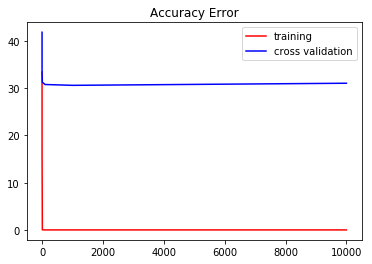

In [13]:
plt.plot(np.array(C),100-np.array(acc_train),color='r',label='training')
plt.plot(np.array(C),100-np.array(acc_cval),color='b',label='cross validation')
plt.title(label='Accuracy Error')
plt.legend()
plt.show()

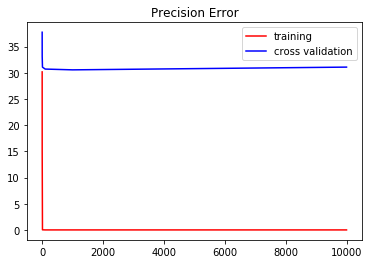

In [14]:
plt.plot(np.array(C),100-np.array(prec_train),color='r',label='training')
plt.plot(np.array(C),100-np.array(prec_cval),color='b',label='cross validation')
plt.title(label='Precision Error')
plt.legend()
plt.show()

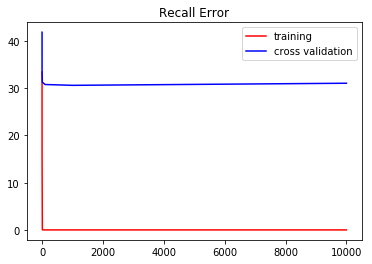

In [15]:
plt.plot(np.array(C),100-np.array(rec_train),color='r',label='training')
plt.plot(np.array(C),100-np.array(rec_cval),color='b',label='cross validation')
plt.title(label='Recall Error')
plt.legend()
plt.show()

In [16]:
print(acc_cval)
print(prec_cval)
print(rec_cval)

[58.136519403538024, 66.51847735482079, 68.72279336852829, 69.20440863202741, 69.38038343984441, 68.93581550430675]
[62.2480671772894, 66.83098805643054, 68.91370566649377, 69.2816746264161, 69.43035687955678, 68.90729851604877]
[58.136519403538024, 66.51847735482079, 68.72279336852829, 69.20440863202741, 69.38038343984441, 68.93581550430675]


As can be seen the model seems to perform better around C=1000 ater this value the model will likeiy suffer of hig-variance (even though we need to go to really large values of C to see that happening). 

For the purpose of the model it is probably good to have an high precision as we are interested in getting as much actual positive predictions. The data show that there is not much difference between accuracy, recall and precision, this is probably due to the fact that we considered a dataset that is more or less uniform in terms of articles per class.

In [17]:
logr = LogisticRegression(n_jobs=n_jobs, C=1000,random_state=42,solver='lbfgs',penalty='l2',multi_class='multinomial')
logr.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=8, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
with open(Config.logr,'wb') as file:
    pickle.dump(logr,file)

## Model Evaluation

We can now consider the problem of model eavaluation. Let's consider the Accuracy, the Precision and the Recall of the trained model on the cross-validation set

In [19]:
y_pred = logr.predict(X_test)
acc_cv_1=accuracy_score(y_test,y_pred)*100
prec_cv_1=precision_score(y_test,y_pred,average='weighted')*100
rec_cv_1=recall_score(y_test,y_pred ,average='weighted')*100

print("Accuracy: {}".format(acc_cv_1))
print("Precision: {}".format(prec_cv_1))
print("Recall: {}".format(rec_cv_1))

Accuracy: 69.38038343984441
Precision: 69.43035687955678
Recall: 69.38038343984441


A precision of 70% is definetly not bad, but also not exceedingly good. Given the type of problem that we are trying to solve though, we can probably conclude that this type of evaluation might be too naive. The classification of scientific articles, especially when considering such a larg number of classes, admits a certain degree of ambiuity. For example, a paper that talks about topological effects in p-wave superconductors, can be considered as talking about superconductivity, but also, alternatively, about strongly interacting systems. The category which best describe the paper is therefore, most of time, a matter of tastes of the author. We can therefore try to explore different ways to evaluate the model, which migth perform better than we think.

A first attempt  in this direction would be to consider if the algorithm can correctly pick up the general subject of the article. To understand the piece of code below we should consider that given a certain class, arXiv separates with a dot the general subject of from the specific one. For example "math.GR" is the category for Group Theory, which is a math subject; "astro-ph.CO" is about Cosmology, which is an astro-phisics subject and so on. This type of approach could be still refined as some classes do not follow this pattern; for example quant-ph is the class for Quantum Physics, which arXiv keeps separated from the classes physics.* , but let's not consider this for the moment, as it might be good enough to keep things simple.

In [20]:
#Remove whatever comes after the dot, if any, in the classes 
y_test_strip=[x[:x.rfind('.')] if x.rfind('.')!=-1 else x for x in y_test]
y_pred=logr.predict(X_test)
y_pred_strip=[x[:x.rfind('.')] if x.rfind('.')!=-1 else x for x in y_pred]
print("Accuracy: {}".format(accuracy_score(y_true=y_test_strip,y_pred=y_pred_strip)))
print("Precision: {}".format(precision_score(y_true=y_test_strip,y_pred=y_pred_strip,average='weighted')))
print("Recall: {}".format(recall_score(y_true=y_test_strip,y_pred=y_pred_strip,average='weighted')))

Accuracy: 0.8744095582106141
Precision: 0.8741224476888958
Recall: 0.8744095582106141


As can be seen the Accuracy of the model made a huge jump. This shows that our model is getting most of the articles subjects correctly and that probably the real accuracy of the model is higher than what we thought. In order to get a better estimate of how good is our model it is probably good to take a step back and to consider what problem that we are trying to solve. We want an application that would return the three best classes that classify a given article, as arXiv allow the author to specify up to three classes for a paper. We can therefore take this into account and consider the classification succesful whenever the training label is one of the best three predicted classes 

In [21]:
def predict_class(X,model): 
    probs=model.predict_proba(X)
    for prob in probs: 
        pos=np.argsort(-prob)
        yield model.classes_[pos[:3]]

def best_of_3(y_pred,y):
    y_best_3=[]
    for i,clss in enumerate(y_pred):
        if y[i] in clss :
            y_best_3.append(y[i])
        else:
            y_best_3.append(clss[0])
    return y_best_3

In [22]:
y_pred_3=predict_class(X_test,logr)
y_pred_best3=best_of_3(y_pred_3,y_test)

In [23]:
print("Accuracy: {}".format(accuracy_score(y_true=y_test,y_pred=y_pred_best3)))
print("Precision: {}".format(precision_score(y_true=y_test,y_pred=y_pred_best3,average='weighted')))
print("Recall: {}".format(recall_score(y_true=y_test,y_pred=y_pred_best3,average='weighted')))

Accuracy: 0.9103454663332408
Precision: 0.9114968701148863
Recall: 0.9103454663332408


These values are really encouraging and suggest that an hypotetical user of the application would be most likely able to get useful suggestions out of the three classes provided by it.